# The Pulse of The Nation

## Packages

First off let's start by importing some of the necessary packages.

In [25]:
# Imports
import requests
import csv
import codecs
import json
import os
import pandas as pd
import re
import matplotlib.pyplot as plt

%matplotlib inline

## Functions

Next, we can define some functions that will be useful.

In [26]:
def requestURL(inputString):
    """Get url source code, else catch errors"""
    if not isinstance(inputString, str):
        raise TypeError('inputString must be a string') 
    r = requests.get(url=inputString)
    if r.status_code != 200:
        raise Exception('Page request unsuccessful: status code {0}'.format(r.status_code))
    return(r.text)

def restrict(inputString, startStr=None, endStr=None):
    """Get a substring from an input, given a start string and an end string"""
    if not isinstance(inputString, str):
        raise TypeError('inputString must be a string')

    startIndex = inputString.index(startStr) + len(startStr) if startStr else 0
    endIndex = inputString.index(endStr) if endStr else len(inputString)
    return(inputString[startIndex:endIndex])


def getDataURLs():
    """Get urls of csvs on survey website"""
    baseURL = 'https://thepulseofthenation.com'
    sourceCode = requestURL(inputString=baseURL)
    downloadSection = restrict(inputString=sourceCode, startStr='<ul class="downloads">', endStr='</ul>')
    downloadList = downloadSection.split('<li>')[1:]
    linkList = [restrict(inputString=x, startStr='href="', endStr='" download>') for x in downloadList]
    urlList = ['{0}{1}'.format(baseURL, link) for link in linkList]
    return urlList

def downloadData(urlList):
    """Given a list of links, get the csv files and merge them into a list of dicts"""
    # Make list of all records as dicts
    data = list()
    for url in urlList:
        print('Downloading data from {0}'.format(url))
        item = requests.get(url)
        content = codecs.iterdecode(item.iter_lines(), 'utf-8')
        csvReader = csv.DictReader(content)
        for record in csvReader:
            # Make sure that q&a's are clean
            item = dict()
            for k, v in record.items():
                item[k.strip()] = v.strip()
            data.append(item)

    # Get all questions
    questionSet = set()
    for record in data:
        for k in record.keys():
            questionSet.add(k)

    # Make sure that every dict in data list has the same questions
    outputData = list()
    for record in data:
        newRecord = {question: 'N/A' for question in questionSet if question not in record}
        newRecord.update(record)
        outputData.append(newRecord)

    return outputData

def pickUp(path):
    """Read in json data file"""
    with open(path) as infile:
        item = json.load(infile)
    return item

def putDown(item, path):
    """Write out json data file"""
    print('Writing to {0}'.format(path))
    with open(path, 'w') as outfile:
        json.dump(item, outfile)

def putDownCSV(item, path):
    """Write out csv data file"""
    print('Writing to {0}'.format(path))
    with open(path, 'w') as outfile:
        dataWriter = csv.DictWriter(outfile, fieldnames=item[0].keys())
        dataWriter.writeheader()
        dataWriter.writerows(item)


Finally we draw this together under a sort of wrapper function.

In [27]:
# Wrapper for initial collection and writing of data
def collectData():
    urlList = getDataURLs()
    print('Found {0} URLs'.format(len(urlList)))
    data = downloadData(urlList)
    print('Collected {0} records'.format(len(data)))
    dataPath = './output/collectedData.json'
    putDown(data, dataPath)
    putDownCSV(data, './output/collectedData.csv')


Now we're ready to collect some data!

## Pulling Data and Initial Exploration

In [28]:
collectData()

Found 3 URLs
Collected 2800 records
Writing to ./output/collectedData.json
Writing to ./output/collectedData.csv


So now we have all of the data collected together, and written into both json and csv formats.
Time to have a look at what's in there - let's start by reading it into a pandas dataframe.

In [29]:
df = pd.read_csv('./output/collectedData.csv')

Now to explore. Let's start by taking a look at what questions were asked in this survey. Might be worth constructing a handy function.

In [30]:
for i, value in enumerate(df.columns.values):
    print('{0}. {1}'.format(i+1, value))

1. From what you have heard or seen, do you mostly agree or mostly disagree with the beliefs of White Nationalists?
2. Do you think it is likely or unlikely that there will be a Civil War in the United States within the next decade?
3. Who would you prefer as president of the United States, Darth Vader or Donald Trump?
4. Do you think poor black people are more likely to benefit from welfare programs than poor white people?
5. If you had to choose, would you rather live in a more equal society or a more unequal society?
6. Would you say you are liberal, conservative, or moderate?
7. What is your highest level of education? (High school or less, Some college, College degree, Graduate degree)
8. q10x
9. If you had to guess, what percentage of Democrats would say that they love America?
10. Now, I'd like you to try to guess the level of wealth equality in America. Out of all the wealth that Americans have, what percentage of that wealth would you guess is owned by the richest 1% of Americ

And then a quick idea of what the response to each of these looks like.

In [31]:
df.head

<bound method NDFrame.head of      From what you have heard or seen, do you mostly agree or mostly disagree with the beliefs of White Nationalists?  \
0                                                   NaN                                                                 
1                                                   NaN                                                                 
2                                                   NaN                                                                 
3                                                   NaN                                                                 
4                                                   NaN                                                                 
5                                                   NaN                                                                 
6                                                   NaN                                                                 
7 

Well... Looks like this data will need a lot of cleaning up. A few things to note at this stage though:
* It looks like a large portion of the questions return categorical answers.
* Some of the questions aren't explicitly stated, e.g. q16x
* There are quite a lot of NaNs --- I suspect that these aren't non-responses, as some responses take the value DK/REF (which I believe stands for Don't Know/Refused). Further to this, are there any row (i.e. respondants) who have NaN for all questions? If so, what does this mean, and can we simply remove these rows?

For now let's get rid of any columns pertaining to questions that aren't explicitly stated. We can start off by defining a handy function that uses regular expressions to identify these column names.

In [32]:
import re

def isBadQuestion(question):
    expressions = [r"Q\d*OTH\d", r"q\d*x"]
    isBad = False
    for expression in expressions:
        if re.match(expression, question):
            isBad = True
    return isBad

And now let's drop each column that pertains to an undefined question.

In [33]:
for question in df.columns.values:
    if isBadQuestion(question):
        df = df.drop(question, axis=1)

for i, question in enumerate(df.columns.values):
    print('{0}. {1}'.format(i+1, question))

1. From what you have heard or seen, do you mostly agree or mostly disagree with the beliefs of White Nationalists?
2. Do you think it is likely or unlikely that there will be a Civil War in the United States within the next decade?
3. Who would you prefer as president of the United States, Darth Vader or Donald Trump?
4. Do you think poor black people are more likely to benefit from welfare programs than poor white people?
5. If you had to choose, would you rather live in a more equal society or a more unequal society?
6. Would you say you are liberal, conservative, or moderate?
7. What is your highest level of education? (High school or less, Some college, College degree, Graduate degree)
8. If you had to guess, what percentage of Democrats would say that they love America?
9. Now, I'd like you to try to guess the level of wealth equality in America. Out of all the wealth that Americans have, what percentage of that wealth would you guess is owned by the richest 1% of Americans? (0 t

Well that looks a little nicer, so time for a few basic plots to make sure there's nothing too ridiculous in here.

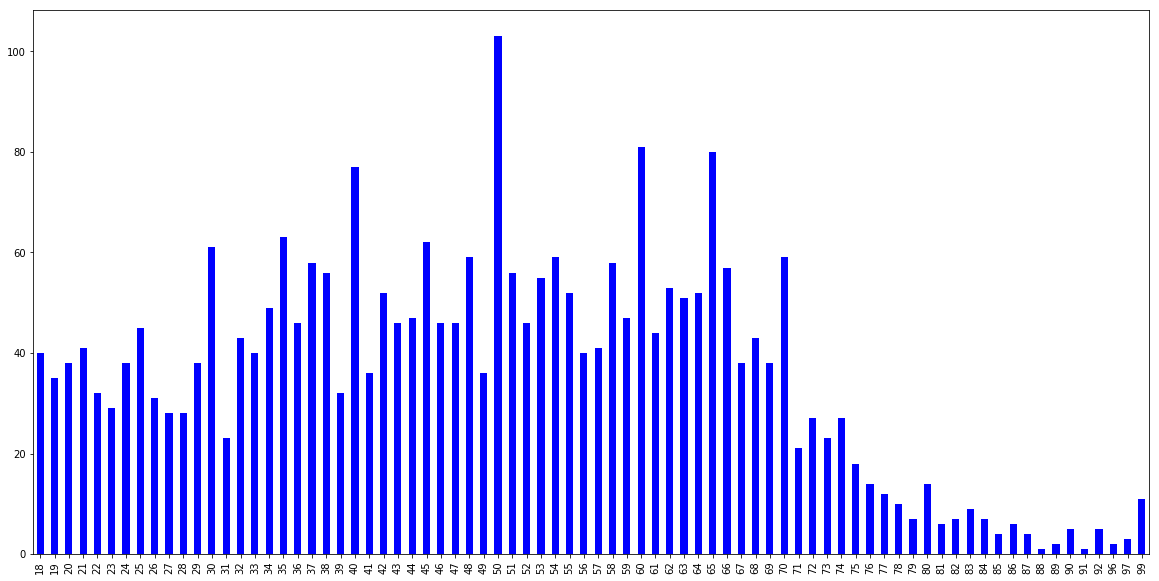

In [55]:
ageCounts = df['Age'].value_counts().sort_index()
ageCounts.plot.bar(color='b', figsize=(20,10))

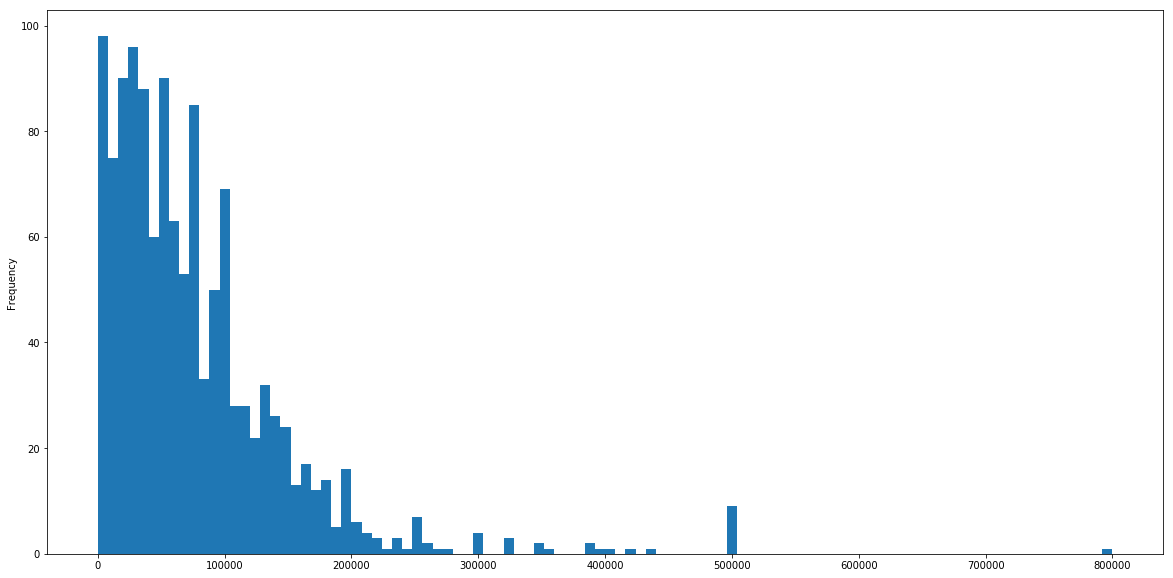

In [85]:
df['lIncome'] = np.log10(df['Income'])
reduced = df[(df['Income'] > 0) & (df['Income'] < 1000000)]
reduced['Income'].plot.hist(bins=100, figsize=(20,10))

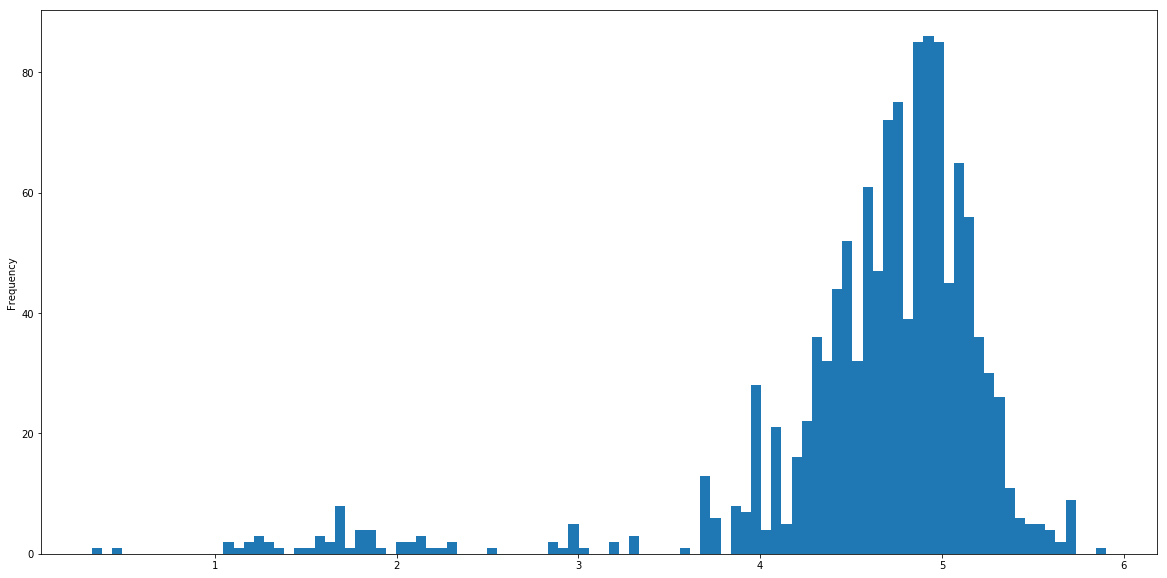

In [86]:
reduced['lIncome'].plot.hist(bins=100, figsize=(20,10))